In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [491]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [492]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [493]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [494]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [495]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


# Part 1: Data Cleaning and Preparation

### Step 1: Joining tables together

In [496]:
# marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [497]:
marketing_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7665 entries, 1 to 10000
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   campaign_id  7665 non-null   int64
dtypes: int64(1)
memory usage: 119.8 KB


In [498]:
# aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [499]:
transactions_agg.head()

,transaction_id,transaction_amount
customer_id,,
1,6,3509.48
2,9,6081.32
3,6,1454.87
4,20,7874.68
5,24,15524.55


In [500]:
# set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [501]:
# join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

In [502]:
# now you have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


### Step 2: Data cleaning

In [503]:
# check missing value
missing_values = joint_data.isnull().sum()
print(missing_values)

join_date                     0
last_purchase_date            0
age                        1009
gender                      533
location                      0
number_of_site_visits         0
number_of_emails_opened       0
number_of_clicks              0
transaction_id                0
transaction_amount            0
campaign_id                2335
dtype: int64


In [504]:
# check the unique
unique_campaign_ids = joint_data['campaign_id'].unique()

# check is there a 0.0
has_zero = 0.0 in unique_campaign_ids

print(f"Unique campaign IDs: {unique_campaign_ids}")
print(f"Does campaign_id contain 0? {has_zero}")

Unique campaign IDs: [ 1.  2. nan  3.  4.]
Does campaign_id contain 0? False


In [505]:
# fill the missing value
joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
joint_data['gender'].fillna('Prefer not to say', inplace=True)
joint_data['campaign_id'].fillna(0.0, inplace=True)

# check missing value again
missing_values = joint_data.isnull().sum()
print(missing_values)

join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_amount         0
campaign_id                0
dtype: int64


/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_6218/813293202.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_6218/813293202.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [506]:
joint_data.describe()

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,43.521200,100.111900,39.862100,19.725300,12.954500,7737.562981,1.257800
std,14.313443,118.625052,46.511719,22.975083,7.191203,4628.799469,0.971511
min,18.000000,1.000000,1.000000,1.000000,1.000000,23.810000,0.000000
25%,32.000000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000
50%,44.000000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000
75%,55.000000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000
max,69.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000


In [507]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,44.0,Prefer not to say,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0


In [508]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      10000 non-null  float64
 3   gender                   10000 non-null  object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              10000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


# Part 2: Feature Engineering

### Step 1: Create new columns

In [509]:
# 将日期字段转换为日期类型
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'])

In [522]:
# Calculate customer lifespan in months
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'])

# Calculate CLV (sum of all transactions per customer)
customer_clv = joint_data.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_clv.columns = ['customer_id', 'CLV']

# Merge the CLV back to the customers dataframe
data = pd.merge(joint_data, customer_clv, on='customer_id')

# Calculate CLV per month
data['CLV_per_month'] = data['CLV'] / data['customer_lifespan']

In [524]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              10000 non-null  int64         
 1   join_date                10000 non-null  datetime64[ns]
 2   last_purchase_date       10000 non-null  datetime64[ns]
 3   age                      10000 non-null  float64       
 4   gender                   10000 non-null  object        
 5   location                 10000 non-null  object        
 6   number_of_site_visits    10000 non-null  int64         
 7   number_of_emails_opened  10000 non-null  int64         
 8   number_of_clicks         10000 non-null  int64         
 9   transaction_id           10000 non-null  int64         
 10  transaction_amount       10000 non-null  float64       
 11  campaign_id              10000 non-null  float64       
 12  customer_lifespan        53 non-n

### Step 2: EDA

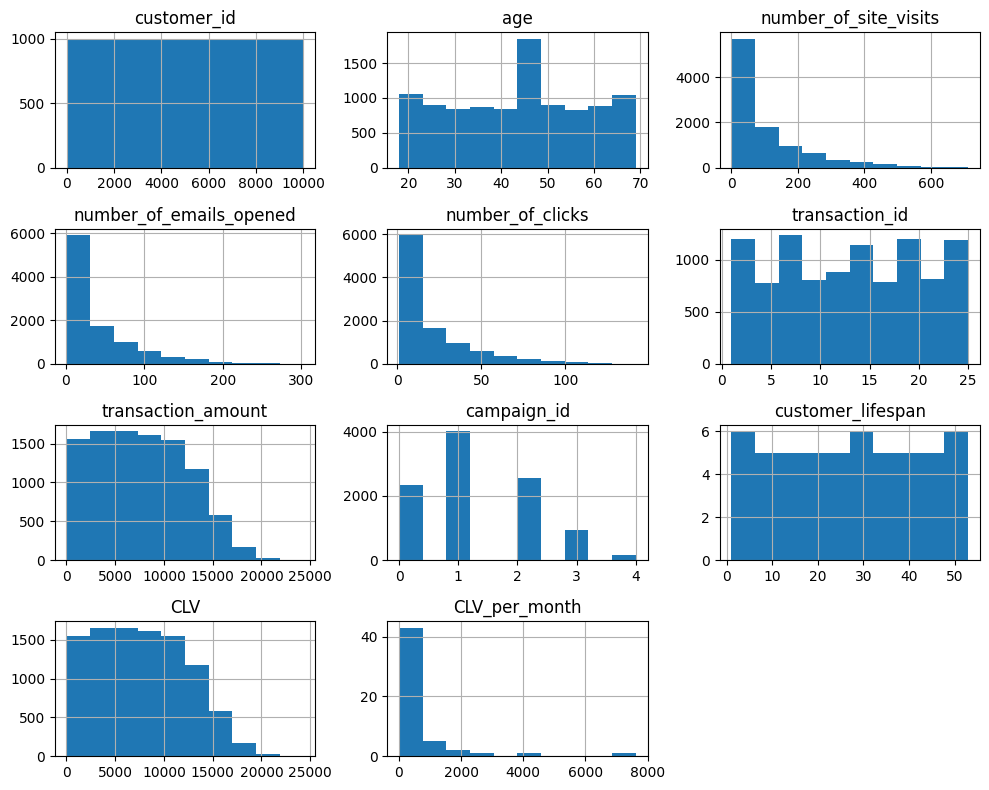

In [512]:
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

Index(['customer_id', 'age', 'number_of_site_visits',
       'number_of_emails_opened', 'number_of_clicks', 'transaction_id',
       'transaction_amount', 'campaign_id', 'customer_lifespan', 'CLV',
       'CLV_per_month'],
      dtype='object')


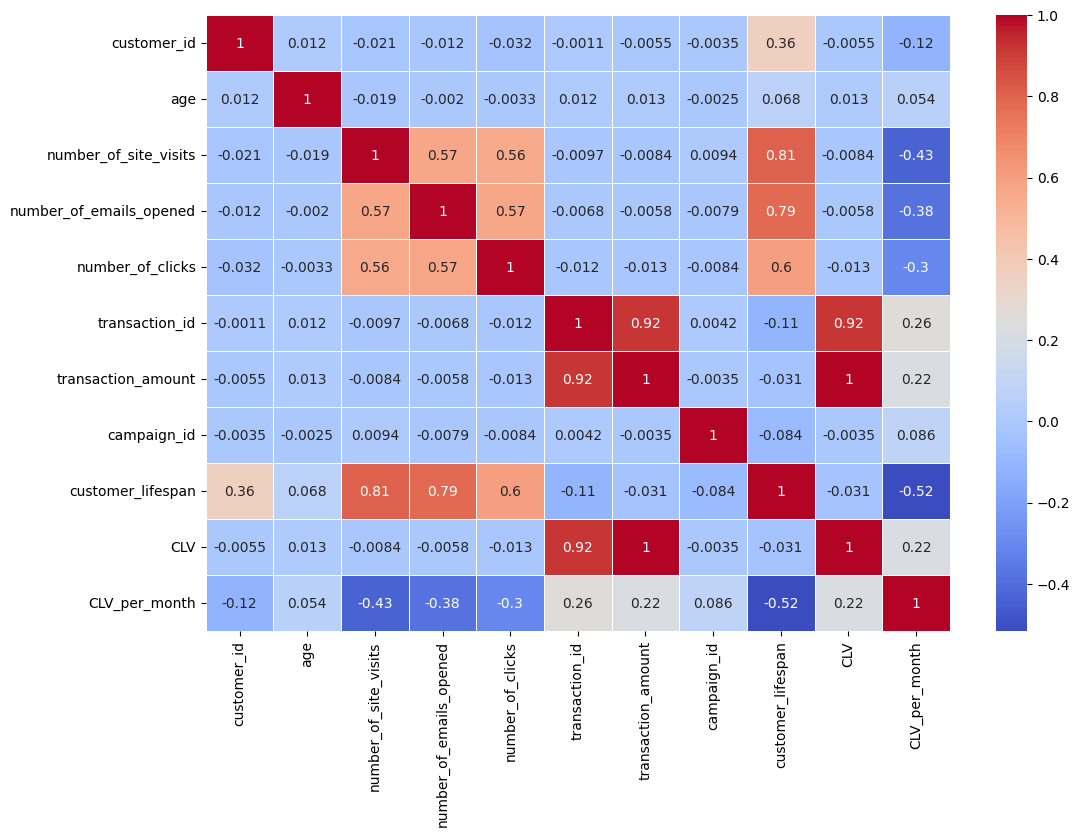

In [515]:
# 选择数值型列
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns
print(numeric_features)

# 计算数值型列的相关性矩阵
correlation_matrix = data[numeric_features].corr()

# 可视化相关性矩阵
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

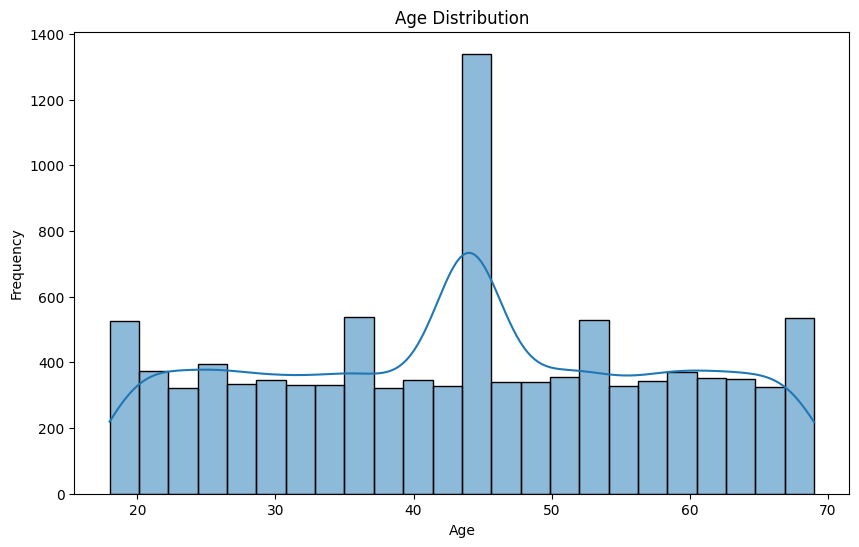

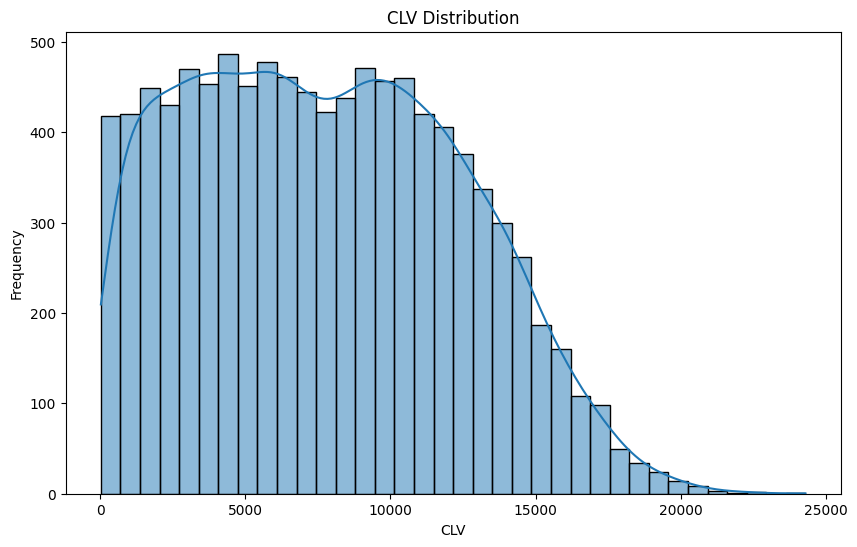

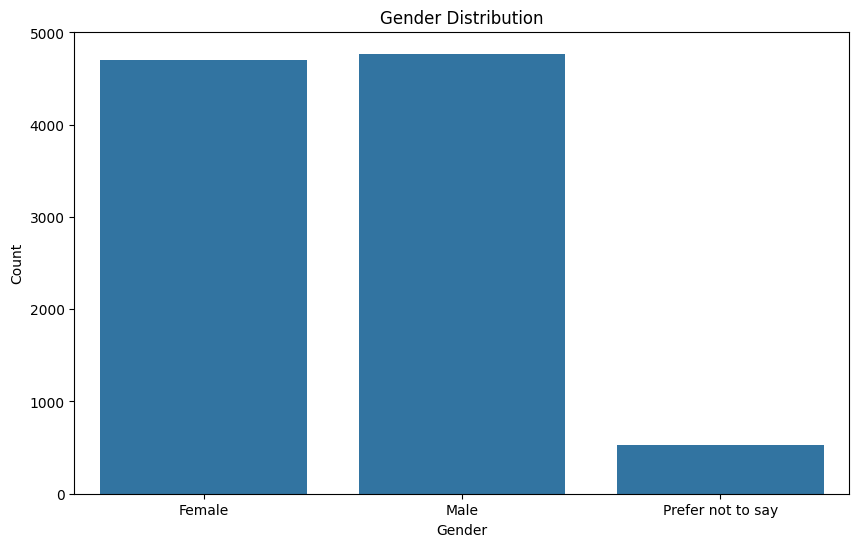

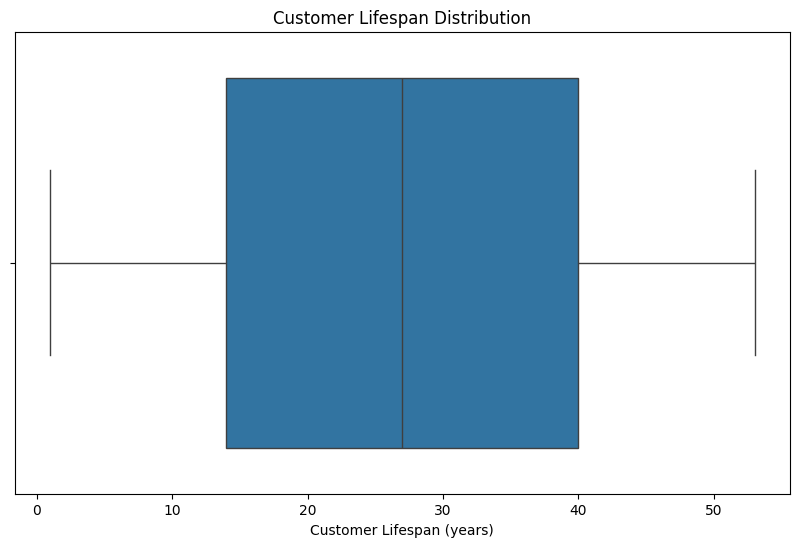

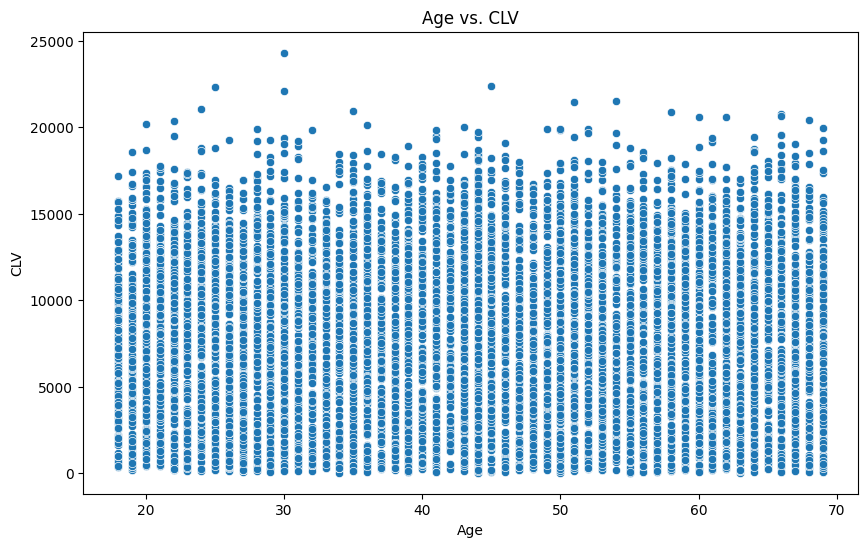

In [516]:
# 年龄分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# CLV 分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(data['CLV'], kde=True)
plt.title('CLV Distribution')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.show()

# 性别分布条形图
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# 客户生命周期分布箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='customer_lifespan')
plt.title('Customer Lifespan Distribution')
plt.xlabel('Customer Lifespan (years)')
plt.show()

# 年龄与 CLV 的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='age', y='CLV')
plt.title('Age vs. CLV')
plt.xlabel('Age')
plt.ylabel('CLV')
plt.show()


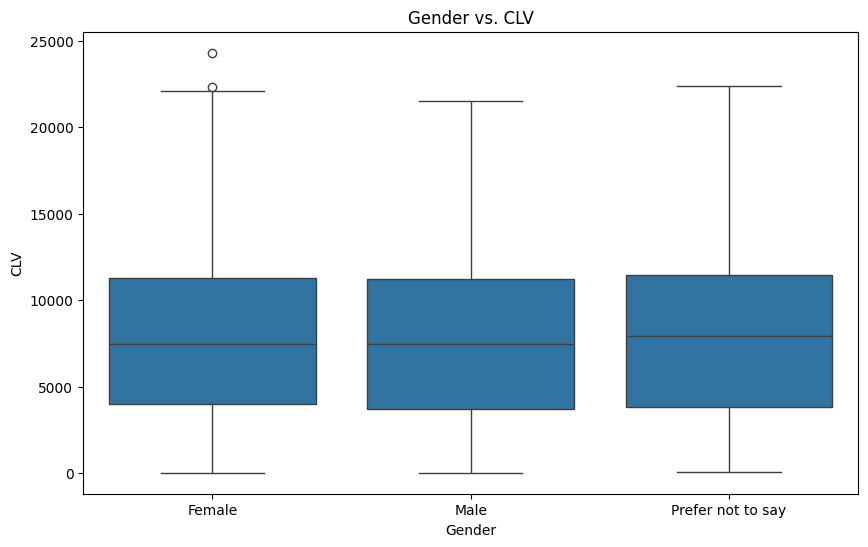

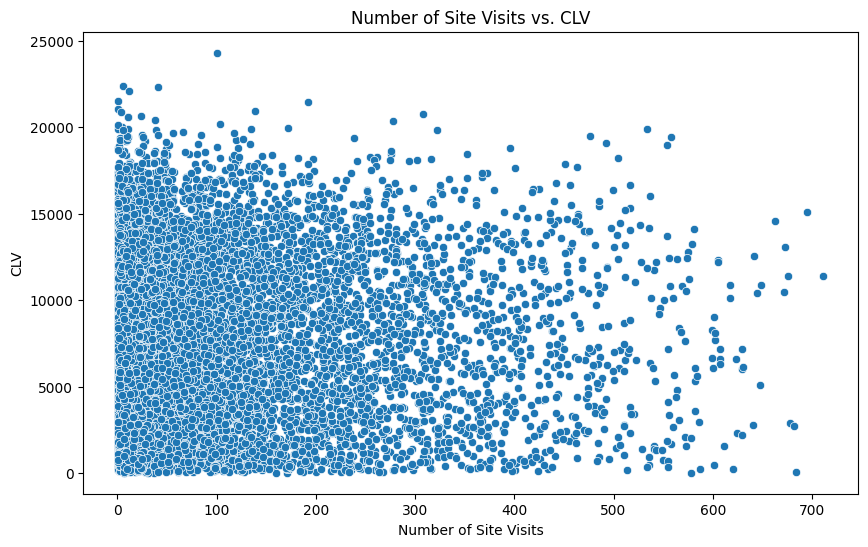

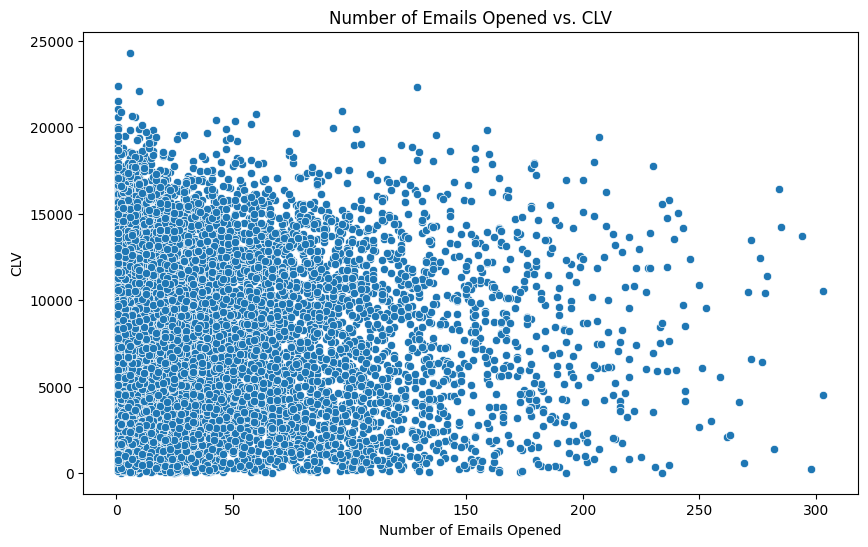

In [517]:
# 性别与CLV的分组分析
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='gender', y='CLV')
plt.title('Gender vs. CLV')
plt.xlabel('Gender')
plt.ylabel('CLV')
plt.show()

# 购买频率与CLV的分组分析
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='number_of_site_visits', y='CLV')
plt.title('Number of Site Visits vs. CLV')
plt.xlabel('Number of Site Visits')
plt.ylabel('CLV')
plt.show()

# 营销活动响应与CLV的分组分析
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='number_of_emails_opened', y='CLV')
plt.title('Number of Emails Opened vs. CLV')
plt.xlabel('Number of Emails Opened')
plt.ylabel('CLV')
plt.show()


In [519]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              10000 non-null  int64         
 1   join_date                10000 non-null  datetime64[ns]
 2   last_purchase_date       10000 non-null  datetime64[ns]
 3   age                      10000 non-null  float64       
 4   gender                   10000 non-null  object        
 5   location                 10000 non-null  object        
 6   number_of_site_visits    10000 non-null  int64         
 7   number_of_emails_opened  10000 non-null  int64         
 8   number_of_clicks         10000 non-null  int64         
 9   transaction_id           10000 non-null  int64         
 10  transaction_amount       10000 non-null  float64       
 11  campaign_id              10000 non-null  float64       
 12  customer_lifespan        53 non-n

# Part 3: Model Building

In [520]:
# 选择与CLV相关性高的特征
features = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'customer_lifespan']
X = data[features]
y = data['CLV']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [521]:
# 建立和训练模型
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model_name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R2 Score': r2_score(y_test, y_pred)
    }

# 打印模型性能
for model_name, metrics in results.items():
    print(f'{model_name} - MSE: {metrics["MSE"]}, R2 Score: {metrics["R2 Score"]}')

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 选择最优模型并进行进一步分析
best_model = min(results, key=lambda x: results[x]['MSE'])
print(f'Best model: {best_model}')

Best model: Random Forest


In [ ]:
# 使用最优模型进行预测
best_model_instance = models[best_model]
joint_data['predicted_CLV'] = best_model_instance.predict(X)

In [ ]:
# 分析客户分层
joint_data['customer_segment'] = pd.qcut(joint_data['predicted_CLV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


In [ ]:
# 输出不同客户分层的CLV均值
print(joint_data.groupby('customer_segment')['predicted_CLV'].mean())

customer_segment
Low            547.819996
Medium        2804.756897
High          7693.018692
Very High    22806.329916
Name: predicted_CLV, dtype: float64


/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_6218/1691503408.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(joint_data.groupby('customer_segment')['predicted_CLV'].mean())
